### Introduction to NetworkX and basic graph visualization
This tutorial is based on Dima Goldenberg's workshop at PyCon Israel 2019.  Full code from Goldenberg's workshop is avaialble at https://github.com/dimgold/pycon_social_networkx.  

The original example was modified to account for changes in API, and simplified for the purposes of this class

In [1]:
import pandas as pd
import networkx as nx
#!pip install colorthief
from colorthief import ColorThief
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
votes_data = pd.read_excel('data/ESC2018_GF.xlsx')

In [3]:
votes_melted = votes_data.melt(
    ['Rank','Running order','Country','Total'],
    var_name = 'Source Country',value_name='points')    

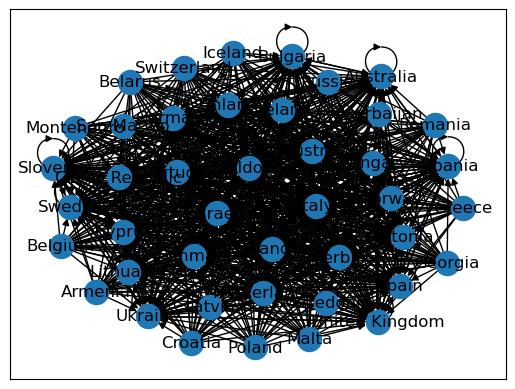

In [4]:
G = nx.from_pandas_edgelist(votes_melted, 
                            source='Source Country',
                            target='Country',
                            edge_attr='points',
                            create_using=nx.DiGraph())
                            
nx.draw_networkx(G)

### Visualization
* The built-in draw method results in a very incomprehensible figure. 
* The method tries to plot a highly connected graph, but with no useful “hints” it’s unable to make a lot of sense from the data. 
* We will enhance the figure by dividing and conquering different visual aspects of the plot with a prior knowledge that we have about the entities:
    * **Position** — each country is assigned according to its geo-position
    * **Style** — each country is recognized by its flag and flag colors
    * **Size** — the size of nodes and edges represents the amount of points

In [5]:
countries = pd.read_excel('countries.xlsx',index_col='Country')

In [6]:
pos_geo = {node: 
        (max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
        max(countries.loc[node]['latitude'],25)) #fixing scale
        for node in G.nodes() }
pos_geo

{'Albania': (20.0, 41.0),
 'Israel': (37.0, 28.0),
 'Cyprus': (30.0, 36.0),
 'Austria': (13.3333, 47.3333),
 'Germany': (9.0, 51.0),
 'Italy': (12.8333, 42.8333),
 'Czech Republic': (15.5, 49.75),
 'Sweden': (15.0, 62.0),
 'Estonia': (26.0, 59.0),
 'Denmark': (10.0, 56.0),
 'Moldova': (29.0, 47.0),
 'Lithuania': (24.0, 56.0),
 'France': (2.0, 46.0),
 'Bulgaria': (25.0, 43.0),
 'Norway': (10.0, 62.0),
 'Ireland': (-8.0, 53.0),
 'Ukraine': (32.0, 49.0),
 'Netherlands': (5.75, 52.5),
 'Serbia': (21.0, 44.0),
 'Australia': (55, 25),
 'Hungary': (20.0, 47.0),
 'Slovenia': (15.0, 46.0),
 'Spain': (-4.0, 40.0),
 'United Kingdom': (-2.0, 54.0),
 'Finland': (26.0, 64.0),
 'Portugal': (-8.0, 39.5),
 'Belarus': (28.0, 53.0),
 'Belgium': (4.0, 50.8333),
 'Croatia': (15.5, 45.1667),
 'Macedonia': (22.0, 41.8333),
 'Greece': (22.0, 39.0),
 'Iceland': (-10, 65.0),
 'Latvia': (25.0, 57.0),
 'Malta': (14.5833, 35.8333),
 'Poland': (20.0, 52.0),
 'Romania': (25.0, 46.0),
 'Russia': (50.0, 60.0),
 'Switz

In [7]:
flags = {}
flag_color = {}
for node in G.nodes():
    flags[node] = 'flags/'+(countries.loc[node]['cc3']).lower().replace(' ','')+'.png'   
    flag_color[node] =  ColorThief(flags[node]).get_color(quality=1)
    


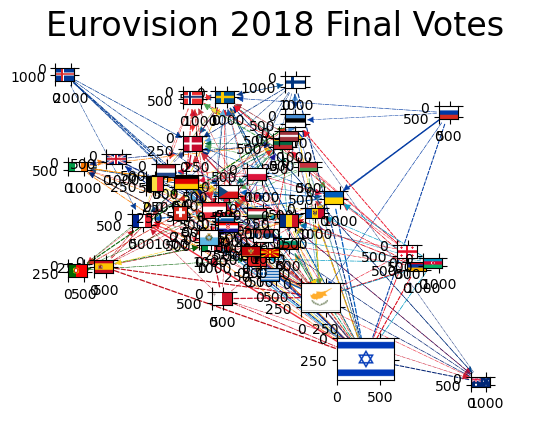

In [8]:
def RGB(red,green,blue): 
    return '#%02x%02x%02x' % (red,green,blue)

ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision 2018 Final Votes',fontsize = 24)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params

styles = ['dotted','dashdot','dashed','solid'] # line styles

pos = pos_geo
    
# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.3: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():      
    imsize = max((0.3*G.in_degree(node,weight='points')
                  /max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)

* The new figure is a bit more readable, and giving us a brief overview of the votes. 
* As a general side-note, plotting networks is often hard and requires to perform thoughtful tradeoffs between the amount of data presented and the communicated message. 
* You can try to explore other network visualization tools such as:
    * Gephi
    * Pyvis
    * GraphChi